---
layout: post
title: "Misleading Figure in 2017 Climate Science Special Report?"
excerpt: "Author Steven Koonin claims that a figure in the 2017 CSSR is misleading. I attempt to simulate the figure to see if it is."
tags: [Climate]
---

I have been reading Steven Koonin's *Unsettled: What Climate Science Tells Us, What It Doesn't, and Why It Matters* and I thought he made an interesting point about extreme temperatures. He claims that the way extreme temperatures are reported in the [2017 Climate Science Special Report](https://science2017.globalchange.gov/) (CSSR) is misleading. Given the importance of climate change and the CSSR in informing our response to it, I thought this claim was worth digging into. In this post, I create a simulation of the climate to see if the CSSR plot truly is misleading.

> For context, the CSSR is, according to their website, an "authoritative assessment of the science of climate change, with a focus on the United States." The CSSR's reports, like the IPCC Assessment Reports, are indisputably among the most important documents in summarizing our understanding of climate change.

Koonin's disagreement is with the claim that extreme temperatures are becoming more common. I've certainly heard that statement many times, so when he contradicted it, it got my attention. Statements about extreme temperatures are in many climate reports, including the 2017 CSSR. In this case, the CSSR makes the following claim in their [executive summary](https://science2017.globalchange.gov/chapter/executive-summary/):

> There have been marked changes in temperature extremes across the contiguous United States. The number of high temperature records set in the past two decades far exceeds the number of low temperature records. (Very high confidence) (Ch. 6, Fig. ES.5)

Figure ES.5 referenced in that statement is reproduced below.

![CSSR Figure 6.5]({{site.baseurl}}/assets/cssr_figure_6_5.png)

There are two separate claims here. One is that there have been "marked changes in temperature extremes" and the other is that "the number of high temperature records set in the past two decades far exceeds the number of low temperature records". The figure is used, presumably, to provide evidence for both points. Koonin's focus is on the first point, so that's where we'll dig in. At first glance, the graph certainly looks like it provides convincing evidence: The ratio of record highs to record lows never exceeds 2:1 from 1930-1960, but does six times between 1960-1990, although it never exceeds 3:1. But from 1990-2016, it exceeds 3:1 four times, going up as high as over 7:1 in 2012.

This plot certainly looks like it shows "marked changes in temperature extremes", so how can this be false? Koonin explains it well:

> To see that, think about the second year (1931) of the analysis. On each of the year’s 365 days, each station that records a temperature even a degree higher than that of the year before will tally a “record high,” while those with a temperature lower will not. We’ll suppose that the CSSR used 1,400 stations (it doesn’t say exactly how many were used, but the 2016 analysis used 1,408); because of the low bar to a record and the random fluctuations of temperature variations, about half the stations will fall on either side of the previous year’s temperature, so that 255,500 record warms (365 × 1,400/2) will be tallied that year. Similarly, about the same number of record colds will be tallied, so that the ratio of record warms to record colds in 1931 (and in the years soon after) will be close to 1. Because these numbers are large (and will remain so in the early years), the ratio won’t vary much from 1:1 early in the period of observation. However, in later years, as the bar to a new record increases, the numbers of records become much smaller, and so the ratio fluctuates much more. The upshot is that by using the running records method, the ratio graph is guaranteed to show a long period of values around 1 at the start of the record, followed by dramatic variations toward the end, creating the impression of large changes in recent decades, even if they aren’t present. While it produces a scary visual, this ratio has almost nothing to do with how temperatures are actually changing.

That's an interesting point. It made me wonder if I could simulate it. I wanted to see what the plot would look like if there was **no** change in warming or temperature extremes. Would we still see the same effect?

## Creating a Simulation

My first question was how to model daily temperatures. I went to Wikipedia and grabbed the "Average high &deg;F" temperatures for each month in the US.

![Average Temperature in the US]({{site.baseurl}}/assets/ave_temp.png)

Then I plotted the data to get an idea of how to simulate it.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from collections import defaultdict
import pandas as pd
from pylab import MaxNLocator
import calendar
plt.rcParams['figure.figsize'] = [10, 8]

In [2]:
temps = [42.6, 46.5, 55.3, 64.4, 73.6, 82.1, 87.1, 85.8, 78.8, 66.9, 53.9, 44.2]

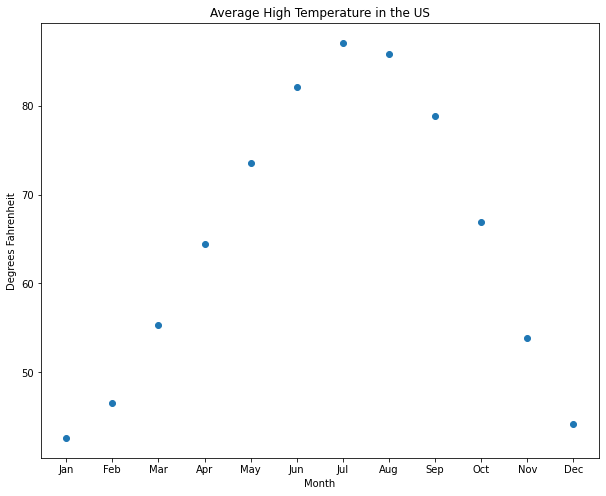

In [3]:
x = calendar.month_abbr[1:]
plt.scatter(x, temps)
plt.title('Average High Temperature in the US')
plt.xlabel('Month')
plt.ylabel('Degrees Fahrenheit');

This looks fairly easy to get a decent approximation with. Based on the shape, I decided to use a cosine function as my model.

In [4]:
def get_baseline_temps(num_points):
    temps = [42.6, 46.5, 55.3, 64.4, 73.6, 82.1, 87.1, 85.8, 78.8, 66.9, 53.9, 44.2]
    x = np.array(range(num_points))
    a = (np.max(temps) - np.min(temps)) / 2
    b = np.mean(temps)
    c = 0.2  # shift
    w = 2 * np.pi / num_points
    return b - a * np.cos((x - c) * w)


Then I plotted it along with the original values to see how good the fit was.

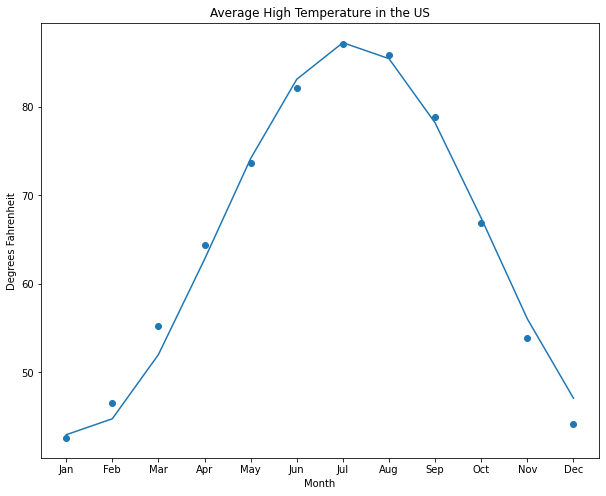

In [5]:
x = calendar.month_abbr[1:]
y = get_baseline_temps(12)
plt.scatter(x, temps)
plt.plot(x, y)
plt.title('Average High Temperature in the US')
plt.xlabel('Month')
plt.ylabel('Degrees Fahrenheit');

Looks nice! But we're going to want daily data, not monthly. So I updated the model to provide daily values.

In [6]:
def plot_temps(temperature, title=None):
    """
    Plot temperature with months on the x-axis
    """
    x = np.array(range(len(temperature)))
    plt.plot(x, temperature)
    plt.title(title)
    plt.xlabel('Month')
    plt.ylabel('Degrees Fahrenheit')
    locator = mdates.MonthLocator()
    fmt = mdates.DateFormatter('%b')
    X = plt.gca().xaxis
    X.set_major_locator(locator)
    X.set_major_formatter(fmt)

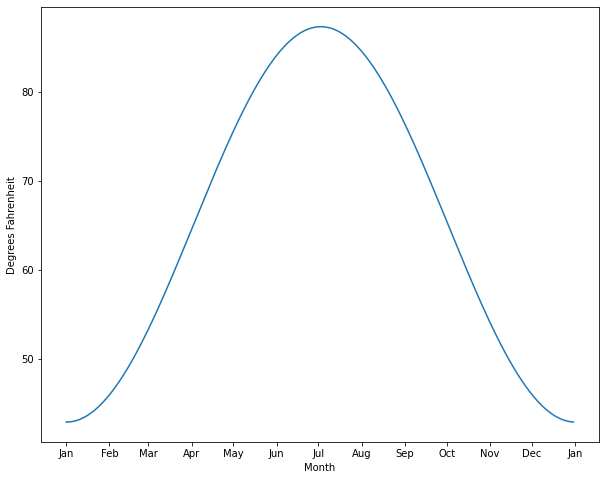

In [7]:
temps = get_baseline_temps(365)
plot_temps(temps, title=None)

That's a good baseline.

To be more realistic, I'll need to add some noise to it. But how much noise should I add? To determine that, I went to [NOAA's website](https://www.ncdc.noaa.gov/cdo-web/search) (kudos to NOAA for making climate data easy to access) and downloaded one year of weather data in San Diego (where I live). Then I chose a weather station that had no missing data and took a look at the data. Here's a plot of it.

In [8]:
df = pd.read_csv('2742964.csv')

In [9]:
station_name = 'USR0000CALP'
mdf = df[df['STATION'] == station_name]

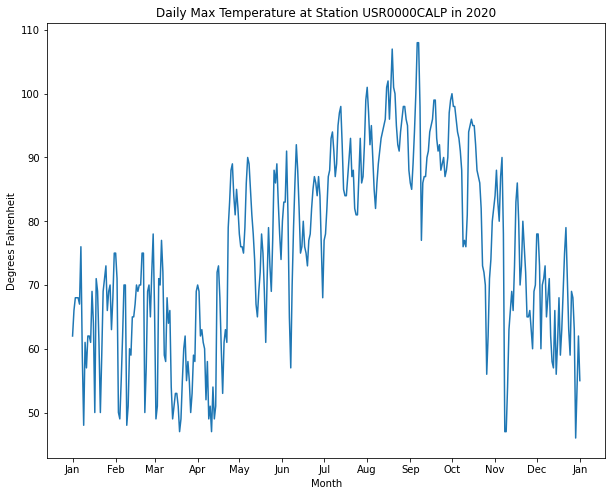

In [10]:
plot_temps(mdf['TMAX'], f'Daily Max Temperature at Station {station_name} in 2020')

In [11]:
daily_var = np.std(mdf['TMAX'])

Then I took the standard deviation of the temperature data to use in my simulation. It was about 14.5. Here's what my simulated daily max temperature looked like.

In [12]:
base_temp = get_baseline_temps(365)
noise = daily_var * np.random.normal(size=365)
final_temp = base_temp + noise

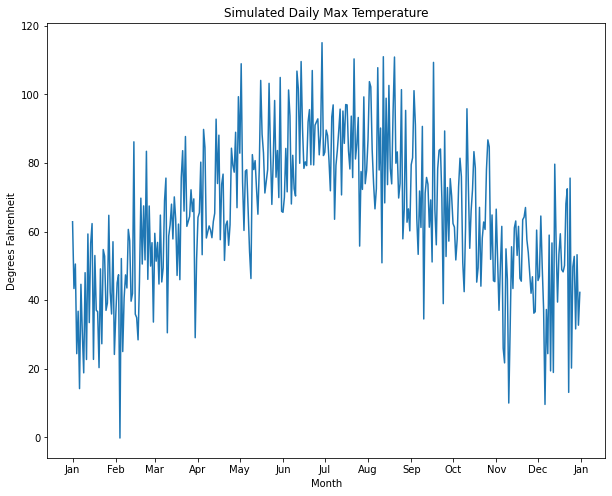

In [13]:
plot_temps(final_temp, 'Simulated Daily Max Temperature')

It's not exact - the simulation appears to have higher frequency changes than the real data, but I think it's good enough for our purposes. We're just looking at the maximum and minimum points, so the rest won't affect the results.

## Finding Record Temperatures

The next step is to generate weather data and find the number of maxima. So I generated 100 years of simulated data and counted the number of temperatures records (highs and lows) each year.

In [15]:
def generate_num_extreme_vals(num_stations, num_years=100, daily_var_mult=daily_var, annual_var_mult=0, warming_per_year=0, random_seed=0):
    """
    Generate the number of extremes (maximum high or minimum low) at each weather station
    """
    DAYS_PER_YEAR = 365
    new_max_vals_per_year = []
    new_min_vals_per_year = []
    num_measurements = num_stations * DAYS_PER_YEAR
    # each station records the number of extreme temps at that location
    max_temps = defaultdict(lambda: -float("inf"))
    min_temps = defaultdict(lambda: float("inf"))
    base_temp = get_baseline_temps(DAYS_PER_YEAR)
    for i in range(num_years):
        annual_variation = np.random.normal(scale=annual_var_mult) + i * warming_per_year
        num_max_vals_that_year = 0
        num_min_vals_that_year = 0
        for station_number in range(num_stations):
            # station_temps = base_temp + station_variation
            for day in range(DAYS_PER_YEAR):
                daily_variation = np.random.normal(scale=daily_var_mult)
                temp = base_temp[day] + annual_variation + daily_variation
                if temp > max_temps[station_number, day]:
                    num_max_vals_that_year += 1
                    max_temps[station_number, day] = temp
                if temp < min_temps[station_number, day]:
                    num_min_vals_that_year += 1
                    min_temps[station_number, day] = temp
        new_max_vals_per_year.append(num_max_vals_that_year)
        new_min_vals_per_year.append(num_min_vals_that_year)
        
    return new_max_vals_per_year, new_min_vals_per_year

In [16]:
max_vals, min_vals = generate_num_extreme_vals(num_stations=1, daily_var_mult=daily_var)

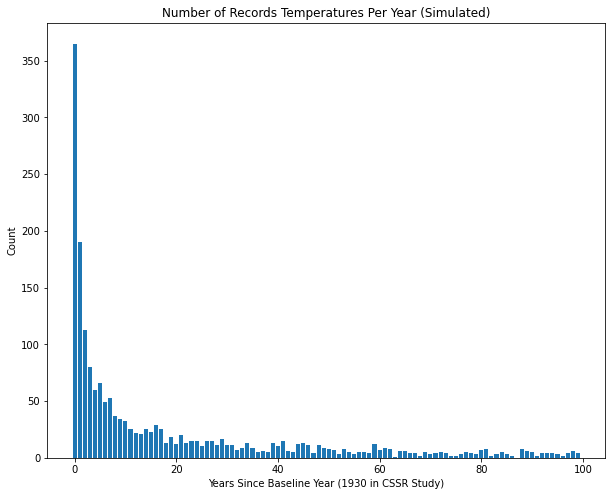

In [17]:
plt.bar(range(len(max_vals)), max_vals)
plt.title('Number of Records Temperatures Per Year (Simulated)')
plt.xlabel('Years Since Baseline Year (1930 in CSSR Study)')
plt.ylabel('Count')
plt.show()

Here's the plot of the number of record temperatures per year. As expected, this starts high (365 for the first year) and drops precipitously. It's easy to see why it would be hard to see a change in the number of extreme temperatures in a graph like this, thus the reason for looking at the ratio.

Converting it to a ratio is simple to do. I'm not sure what the original authors did in the case where there were zero extreme values in a year, so to avoid a "division by zero" error, I converted the zeros to ones. I don't believe this will significantly affect the results.

In [18]:
def get_ratio(max_vals, min_vals):
    cleaned_max = [max(x, 1) for x in max_vals]
    cleaned_min = [max(x, 1) for x in min_vals]
    ratio = []
    for index, extreme_vals in enumerate(zip(cleaned_max, cleaned_min)): # zip them!!!
        if extreme_vals[0] > extreme_vals[1]:
            ratio.append(extreme_vals[0] / extreme_vals[1])
        else:
            ratio.append(extreme_vals[1] / extreme_vals[0])
    return ratio

In [19]:
ratio = get_ratio(max_vals, min_vals)

In [20]:
def plot_ratio(ratio, num_stations=1):
    plt.bar(range(len(ratio)), ratio)
    title = f'Frequency of Extreme Temperatures for {num_stations} Weather Station'
    title += 's' if num_stations > 1 else ''
    plt.title(title)
    plt.xlabel('Years Since Baseline Year (1930 in CSSR Study)')
    plt.ylabel('Ratio of Daily Temperature Records (Simulated)')
    plt.ylim(0, 8)
    plt.show()

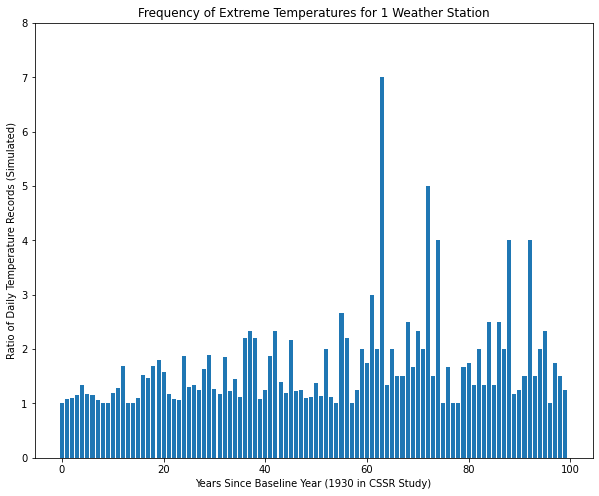

In [21]:
plot_ratio(ratio)

Here's the first graph that's starting to look like the original CSSR graph. Note that I'm not coloring it by whether there were more highs or lows - I'm just interested in whether temperature extremes are becoming more common, not whether they're for hot or cold days.

The effect Koonin was concerned about does occur. The baseline rises even though there is no change in the underlying climate.

## Running the Experiment

I ran the experiment five more times to make sure I got similar results.

In [22]:
def run_experiment_with_seed(seed, num_stations=1, **kwargs):
    max_vals, min_vals = generate_num_extreme_vals(num_stations, random_seed=seed, **kwargs)
    ratio = get_ratio(max_vals, min_vals)
    plot_ratio(ratio, num_stations)

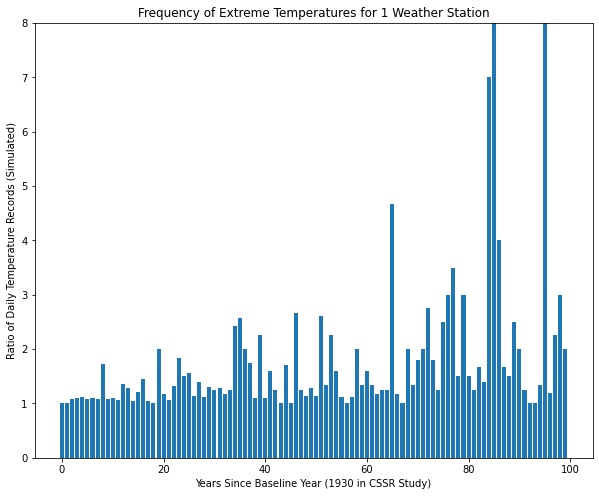

In [23]:
run_experiment_with_seed(1)

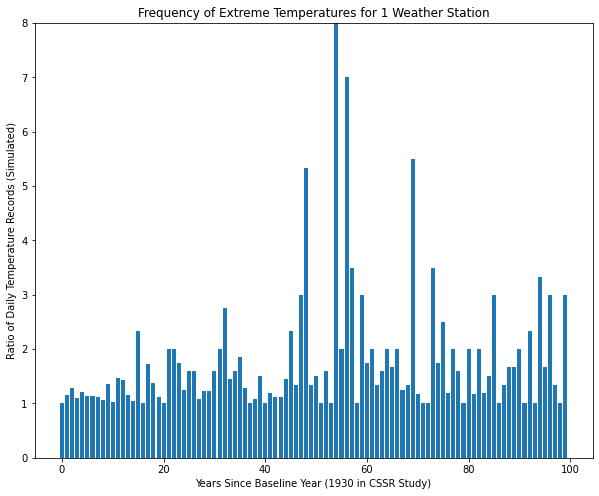

In [24]:
run_experiment_with_seed(2)

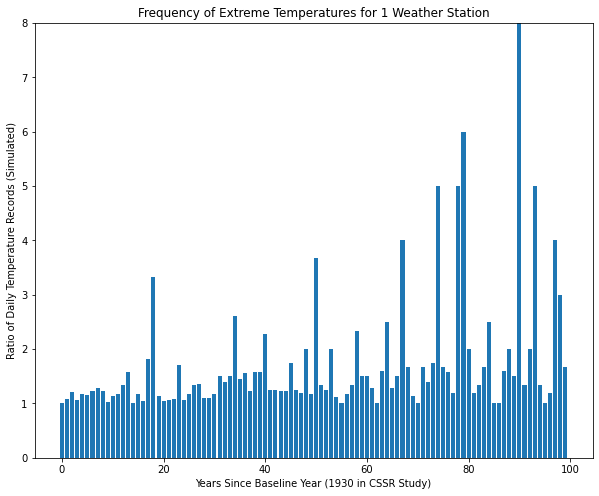

In [25]:
run_experiment_with_seed(3)

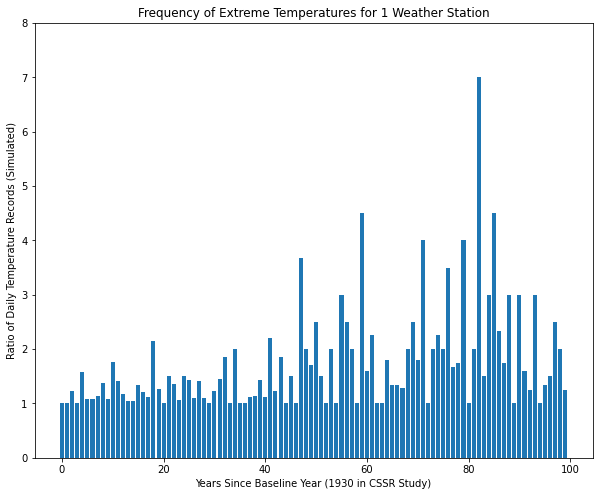

In [26]:
run_experiment_with_seed(4)

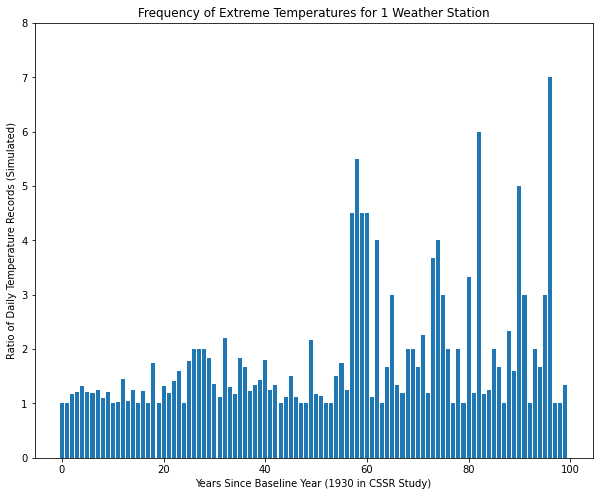

In [27]:
run_experiment_with_seed(5)

In all of them, the results paint the same picture - these plots suggest more extreme weather events in the second half of the dataset even though there is no change in the simulated data.

However, Koonin believes that the original study used around 1,408 weather stations, not just one. So how does that affect the results? I reran the simulation to see.

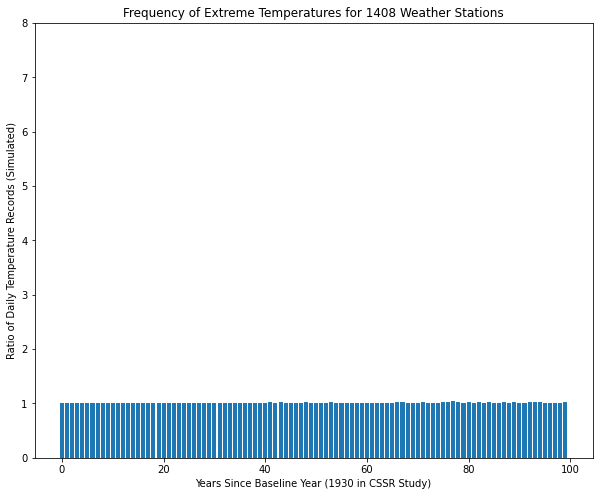

In [28]:
run_experiment_with_seed(1, num_stations=1408)

Averaged over that many weather stations, the effect completely disappears. However, given the large number of measurements, my plot doesn't look anything like the figure in the climate report either. And I don't think that's just because the world is warming and my simulation isn't. Nearly all of my values are near 1 in my plot and very few of theirs are. Even when there were more record lows than highs all through the '60s and '70s, the ratios were mostly around 1.5-2:1. My values are all within 0.1 of 1:1.

Looking back at the CSSR figure (reproduced again below so you don't have to scroll up), 2014 had over twice as many records *lows* as records *highs*, but then 2015 had over twice as many record *highs* as record *lows*. How can this be with over half a million (1408 * 365) independent measurements? There's no way that could happen if every day were uncorrelated to the rest of the days in the year, so I should add an "annual variation" term to account for hotter and colder years. This term would help explain why the data looks the way it does.

![CSSR Figure 6.5]({{site.baseurl}}/assets/cssr_figure_6_5.png)

## Adding Annual Variation Term

To add a term for annual variation, I needed to figure out the right amount. So I went back to [NOAA's website](https://www.ncdc.noaa.gov/cdo-web/search) and downloaded the global average max temperature for every year from 2002 (the first available date at the station I've been using) to 2020. Here's what a plot of that looks like.

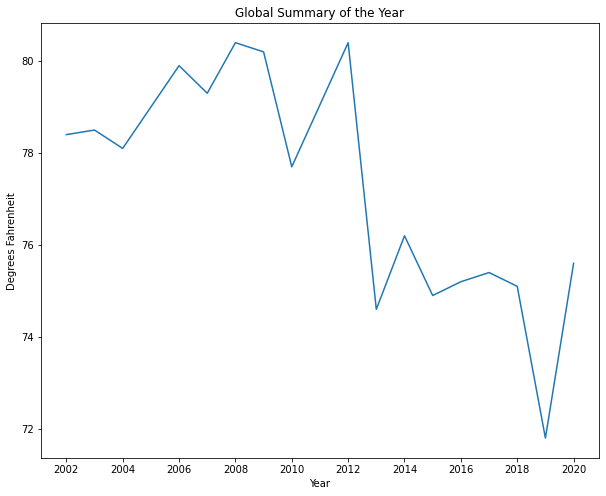

In [29]:
df = pd.read_csv('2742989.csv')
ax = plt.figure().gca()
plt.plot(df['DATE'], df['TMAX'])
plt.title('Global Summary of the Year')
plt.xlabel('Year')
plt.ylabel('Degrees Fahrenheit');
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

In [30]:
annual_var = np.std(df['TMAX'])

The standard deviation of the global summary is 2.4, so that's what I used for my annual variation multiplier.

Then I ran the experiment again. I ran it five times to be sure.

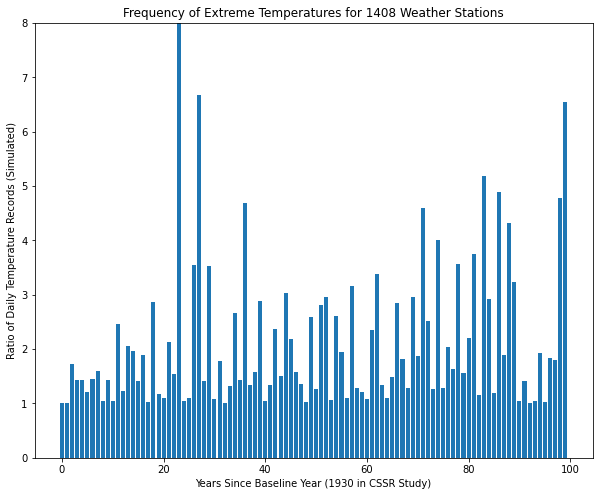

In [31]:
run_experiment_with_seed(1, num_stations=1408, annual_var_mult=annual_var)

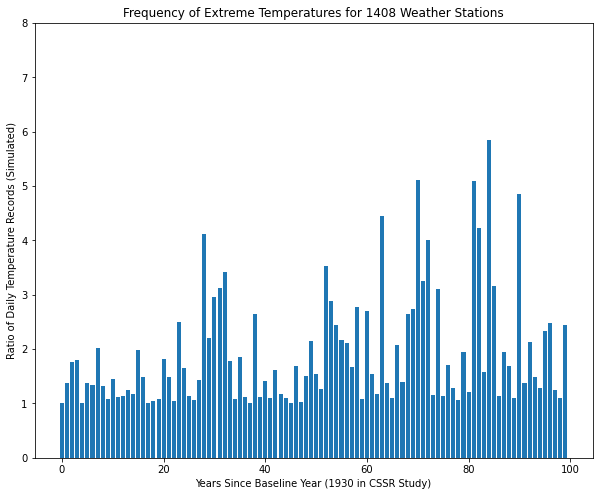

In [32]:
run_experiment_with_seed(2, num_stations=1408, annual_var_mult=annual_var)

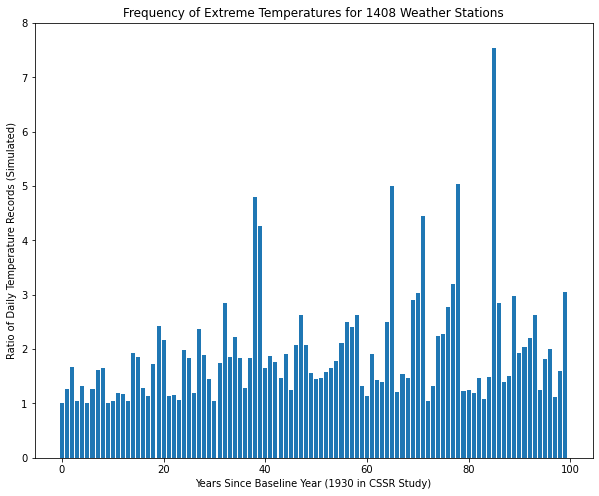

In [33]:
run_experiment_with_seed(3, num_stations=1408, annual_var_mult=annual_var)

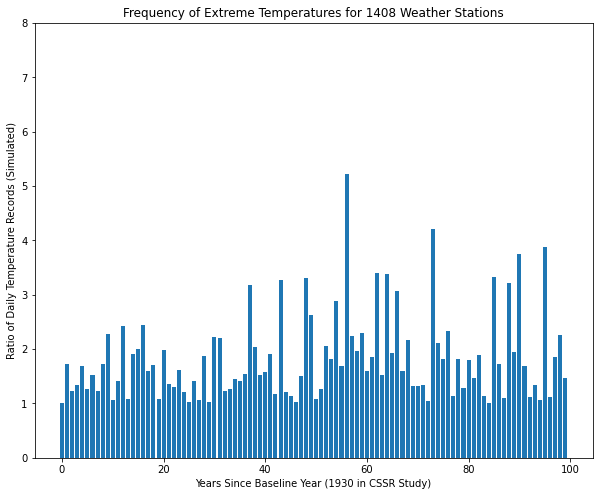

In [34]:
run_experiment_with_seed(4, num_stations=1408, annual_var_mult=annual_var)

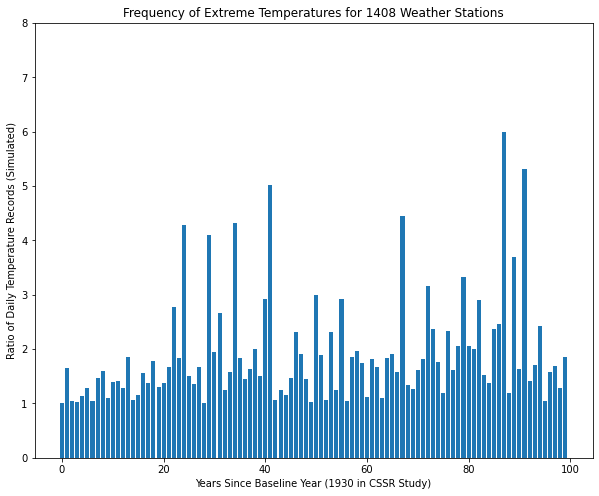

In [35]:
run_experiment_with_seed(5, num_stations=1408, annual_var_mult=annual_var)

This is starting to look like the CSSR figure. However, there is more variance in the early years than there was in the real data, so there's still a difference I'm missing. I *do* think that these plots suggest that extreme weather is increasing, which we know is not true of the simulated data. To me, this supports Koonin's statement that this graph can be misleading.

## Conclusion

Although my simple simulation wasn't able to reproduce an exact replica of the CSSR figure, I did get a good feel for the potential pitfalls when presenting data this way. Given what I saw, my conclusion is that Koonin is right in his criticism of this figure. The way the data is presented makes it look like there is a significant increase in the number of extreme events, even when there isn't. I'm not just basing this on the plots shown above, but also from the various iterations I went through in making this post. I tried a variety of methods to see if I could reproduce the original figure, and I'm convinced that this figure can make effects appear that aren't true in the underlying data. This is unfortunate because the underlying claim may be true, but this graph cannot be used as evidence to support that conclusion.

> A version of this post with all the code is available [here](https://nbviewer.org/github/jss367/JupyterNotebooks/blob/master/2021-10-14-misleading-figure-in-2017-climate-science-special-report.ipynb).